In [38]:
import math

import torch

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from ale_py import ALEInterface
from ale_py.roms import LostLuggage

from tqdm import tqdm

In [20]:
ale = ALEInterface()
ale.loadROM(LostLuggage)
env = gym.make('ALE/LostLuggage-v5')

In [21]:
env = gym.make('ALE/LostLuggage-v5')

In [22]:
num_episodes = 1000

In [23]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)
    

In [31]:
def reinforce(n_episodes):
    input_size = env.action_space.n
    hidden_size = input_size * 8
    output_size = input_size
    learning_rate = 1e-8

    total_rewards = []

    poilicy_network = PolicyNetwork(input_size, hidden_size, output_size)
    optimizer = optim.Adam(poilicy_network.parameters(), lr=learning_rate)

    for _ in tqdm(range(n_episodes)):
        env.reset()
        actions = np.zeros((env.action_space.n,))
        log_probs = []
        rewards = []
        is_done = False

        while not is_done:
            action_tensor = torch.from_numpy(actions).float().unsqueeze(0)
            action_probs = poilicy_network(action_tensor)
            action = torch.multinomial(action_probs, 1).item()
            log_probs.append(torch.log(action_probs[0][action]))
            _, reward, is_done, _, _ = env.step(action)
            rewards.append(reward)
        
        total_rewards.append(sum(rewards))

        returns = []
        G = 0
        for reward in rewards[::-1]:
            G = reward + 0.9 * G
            returns.insert(0, G)

        policy_loss = []

        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)
        
        optimizer.zero_grad()
        optimizer.step()
    
    return total_rewards

In [32]:
total_rewards = reinforce(num_episodes)

100%|██████████| 1000/1000 [11:33<00:00,  1.44it/s]


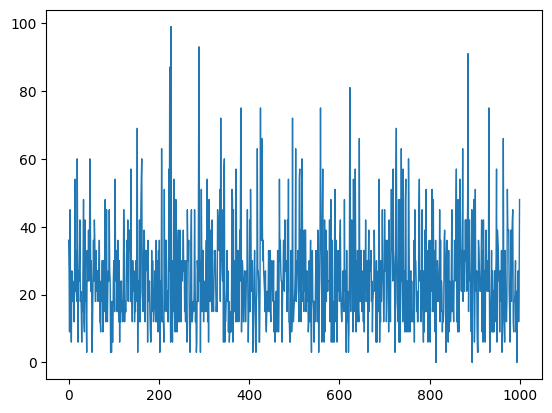

In [33]:
plt.plot(range(num_episodes), total_rewards, linewidth=1)

In [34]:
mean_reward = np.mean(total_rewards)
std_reward = np.std(total_rewards)

In [35]:
print(f'Математическое ожидание: {mean_reward}')
print(f'Стандартное отклонение: {std_reward}')

Математическое ожидание: 25.063
Стандартное отклонение: 14.53475252627302


In [36]:
delta = 0.1

In [39]:
lower_bound = mean_reward - 1.645 * (std_reward / math.sqrt(num_episodes))

In [40]:
upper_bound = mean_reward + 1.645 * (std_reward / math.sqrt(num_episodes))

In [41]:
print(f'({lower_bound}, {upper_bound})')

(24.306909913196993, 25.819090086803005)


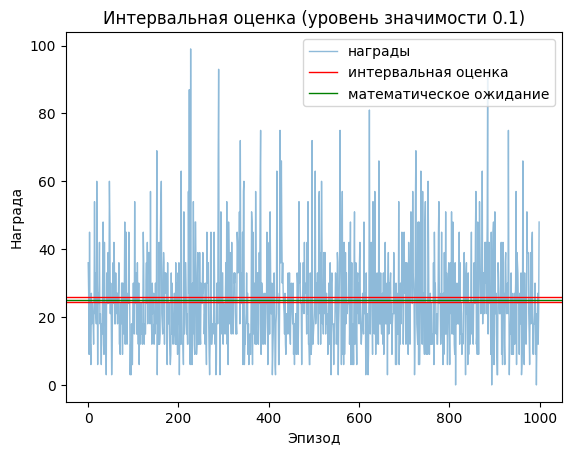

In [43]:
plt.plot(range(num_episodes), total_rewards, alpha = 0.5, linewidth=1)
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('Интервальная оценка (уровень значимости 0.1)')
plt.axhline(upper_bound, linewidth=1, color='red')
plt.axhline(mean_reward, linewidth=1, color='green')
plt.axhline(lower_bound, linewidth=1, color='red')
plt.legend(['награды', 'интервальная оценка', 'математическое ожидание'])
plt.show()

In [44]:
lower_bound = mean_reward - 1.96 * (std_reward / math.sqrt(num_episodes))

In [45]:
upper_bound = mean_reward + 1.96 * (std_reward / math.sqrt(num_episodes))

In [46]:
print(f'({lower_bound}, {upper_bound})')

(24.162126705085782, 25.963873294914215)


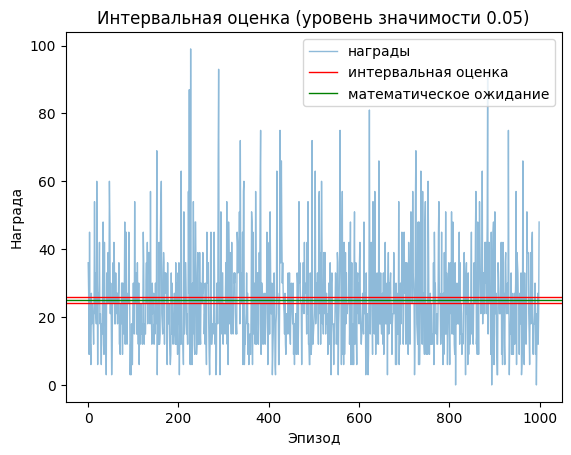

In [54]:
plt.plot(range(num_episodes), total_rewards, alpha = 0.5, linewidth=1)
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('Интервальная оценка (уровень значимости 0.05)')
plt.axhline(upper_bound, linewidth=1, color='red')
plt.axhline(mean_reward, linewidth=1, color='green')
plt.axhline(lower_bound, linewidth=1, color='red')
plt.legend(['награды', 'интервальная оценка', 'математическое ожидание'])
plt.show()